In [1]:
%matplotlib inline

# Experiment 2

In [3]:
"""
A non-blending lightGBM model that incorporates portions and ideas from various public kernels.
"""
DEBUG = False
WHERE = 'kaggle'
FILENO = 4
NCHUNK = 32000000
OFFSET = 75000000
VAL_RUN = False

MISSING32 = 999999999
MISSING8 = 255
PUBLIC_CUTOFF = 4032690

if WHERE=='kaggle':
	inpath = '../../../data/adfraud/'
	pickle_path ='../../../data/adfraud/'
	suffix = ''
	outpath = ''
	savepath = ''
	oofpath = ''
	cores = 4
elif WHERE=='gcloud':
	inpath = '../.kaggle/competitions/talkingdata-adtracking-fraud-detection/'
	pickle_path = '../data/'
	suffix = '.zip'
	outpath = '../sub/'
	oofpath = '../oof/'
	savepath = '../data/'
	cores = 7

import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt
import os

def do_count( df, group_cols, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Aggregating by ", group_cols , '...' )
    gp = df[group_cols][group_cols].groupby(group_cols).size().rename(agg_name).to_frame().reset_index()
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_countuniq( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Counting unqiue ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )
    
def do_cumcount( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Cumulative count by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].cumcount()
    df[agg_name]=gp.values
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_mean( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Calculating mean of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].mean().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_var( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Calculating variance of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].var().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

debug = DEBUG
if debug:
    print('*** debug parameter set: this is a test run for debugging purposes ***')

    
if VAL_RUN:
    nrows=122071522
    outpath = oofpath
else:
    nrows=184903890
nchunk=NCHUNK
val_size=2500000
frm=nrows-OFFSET
if debug:
    frm=0
    nchunk=100000
    val_size=10000
to=frm+nchunk
fileno = FILENO

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32',
        }

if VAL_RUN:
    print('loading train data...',frm,to)
    train_df = pd.read_pickle( pickle_path+"training.pkl.gz" )[frm:to]
    train_df['click_time'] = pd.to_datetime( train_df.click_time )
    print('loading test data...')
    if debug:
        public_cutoff = 10000
        test_df = pd.read_pickle( pickle_path+"validation.pkl.gz" )[:30000]
        test_df['click_time'] = pd.to_datetime( test_df.click_time )
        y_test = test_df['is_attributed'].values
        test_df.drop(['is_attributed'],axis=1,inplace=True)
    else:
        public_cutoff = PUBLIC_CUTOFF
        test_df = pd.read_pickle( pickle_path+"validation.pkl.gz" )
        test_df['click_time'] = pd.to_datetime( test_df.click_time )
        y_test = test_df['is_attributed'].values
        test_df.drop(['is_attributed'],axis=1,inplace=True)
else:
    print('loading train data...',frm,to)
    train_df = pd.read_csv(inpath+"train.csv", parse_dates=['click_time'], skiprows=range(1,frm), nrows=to-frm, dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])
    print('loading test data...')
    if debug:
        test_df = pd.read_csv(inpath+"test.csv", nrows=100000, parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
    else:
        test_df = pd.read_csv(inpath+"test.csv", parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
    train_df['click_id'] = MISSING32
    train_df['click_id'] = train_df.click_id.astype('uint32')


len_train = len(train_df)
test_df['is_attributed'] = MISSING8
test_df['is_attributed'] = test_df.is_attributed.astype('uint8')
train_df=train_df.append(test_df)

del test_df
gc.collect()

print('Extracting new features...')
train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('uint8')
train_df['day'] = pd.to_datetime(train_df.click_time).dt.day.astype('uint8')

print('Extracting aggregation features...')

train_df = do_cumcount( train_df, ['ip', 'device', 'os'], 'app', 'X1', show_max=True ); gc.collect()
train_df = do_cumcount( train_df, ['ip'], 'os', 'X7', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip'], 'channel', 'X0', 'uint8', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip', 'day'], 'hour', 'X2', 'uint8', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip'], 'app', 'X3', 'uint8', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip', 'app'], 'os', 'X4', 'uint8', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip'], 'device', 'X5', 'uint16', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['app'], 'channel', 'X6', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip', 'device', 'os'], 'app', 'X8', show_max=True ); gc.collect()
train_df = do_count( train_df, ['ip', 'day', 'hour'], 'ip_tcount', show_max=True ); gc.collect()
train_df = do_count( train_df, ['ip', 'app'], 'ip_app_count', show_max=True ); gc.collect()
train_df = do_count( train_df, ['ip', 'app', 'os'], 'ip_app_os_count', 'uint16', show_max=True ); gc.collect()
train_df = do_var( train_df, ['ip', 'day', 'channel'], 'hour', 'ip_tchan_count', show_max=True ); gc.collect()
train_df = do_var( train_df, ['ip', 'app', 'os'], 'hour', 'ip_app_os_var', show_max=True ); gc.collect()
train_df = do_var( train_df, ['ip', 'app', 'channel'], 'day', 'ip_app_channel_var_day', show_max=True ); gc.collect()
train_df = do_mean( train_df, ['ip', 'app', 'channel'], 'hour', 'ip_app_channel_mean_hour', show_max=True ); gc.collect()

print('Doing nextClick...')
predictors=[]
new_feature = 'nextClick'
D=2**26
train_df['category'] = (train_df['ip'].astype(str) + "_" + train_df['app'].astype(str) + "_" + train_df['device'].astype(str) \
        + "_" + train_df['os'].astype(str)).apply(hash) % D
click_buffer= np.full(D, 3000000000, dtype=np.uint32)
train_df['epochtime']= train_df['click_time'].astype(np.int64) // 10 ** 9
next_clicks= []
for category, t in zip(reversed(train_df['category'].values), reversed(train_df['epochtime'].values)):
    next_clicks.append(click_buffer[category]-t)
    click_buffer[category]= t
del(click_buffer)
QQ= list(reversed(next_clicks))
train_df.drop(['epochtime','category','click_time'], axis=1, inplace=True)
train_df[new_feature] = pd.Series(QQ).astype('float32')
predictors.append(new_feature)
train_df[new_feature+'_shift'] = train_df[new_feature].shift(+1).values
predictors.append(new_feature+'_shift')
del QQ, next_clicks
gc.collect()

print("vars and data type: ")
train_df.info()
train_df['ip_tcount'] = train_df['ip_tcount'].astype('uint16')
train_df['ip_app_count'] = train_df['ip_app_count'].astype('uint16')
train_df['ip_app_os_count'] = train_df['ip_app_os_count'].astype('uint16')

target = 'is_attributed'
predictors.extend(['app','device','os', 'channel', 'hour', 'day',
              'ip_tcount', 'ip_tchan_count', 'ip_app_count',
              'ip_app_os_count', 'ip_app_os_var',
              'ip_app_channel_var_day','ip_app_channel_mean_hour',
              'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8'])
categorical = ['app', 'device', 'os', 'channel', 'hour', 'day']
print('predictors',predictors)

test_df = train_df[len_train:]
val_df = train_df[(len_train-val_size):len_train]
train_df = train_df[:(len_train-val_size)]

print("train size: ", len(train_df))
print("valid size: ", len(val_df))
print("test size : ", len(test_df))

test_df.to_pickle('test.pkl.gz')
del test_df
gc.collect()

print("Training...")
start_time = time.time()

objective='binary' 
metrics='auc'
early_stopping_rounds=30 
verbose_eval=True 
num_boost_round=1000
categorical_features=categorical
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': objective,
    'metric':metrics,
    'learning_rate': 0.10,
    #'is_unbalance': 'true', # replaced with scale_pos_weight argument
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':200, # because training data is extremely unbalanced 
    'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 0,  # L2 regularization term on weights
    'nthread': cores,
    'verbose': 0,
    'metric':metrics
}

print("preparing validation datasets")
xgtrain = lgb.Dataset(train_df[predictors].values, label=train_df[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
                      
print( train_df[predictors].head() )
print( train_df[target].head() )
print( val_df[predictors].head() )
print( val_df[target].head() )

del train_df
if WHERE != 'kaggle':
    xgtrain.save_binary('xgtrain.bin')
    del xgtrain
xgvalid = lgb.Dataset(val_df[predictors].values, label=val_df[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
del val_df
gc.collect()

evals_results = {}

if WHERE != 'kaggle':
    xgtrain = lgb.Dataset('xgtrain.bin',
                          feature_name=predictors,
                          categorical_feature=categorical
                          )
                      
print( lgb_params )
bst = lgb.train(lgb_params, 
                 xgtrain, 
                 valid_sets=[xgvalid], 
                 valid_names=['valid'], 
                 evals_result=evals_results, 
                 num_boost_round=num_boost_round,
                 early_stopping_rounds=early_stopping_rounds,
                 verbose_eval=10, 
                 feval=None)

print("\nModel Report")
print("bst.best_iteration: ", bst.best_iteration)
print(metrics+":", evals_results['valid'][metrics][bst.best_iteration-1])


print('[{}]: model training time'.format(time.time() - start_time))

# if WHERE!='gcloud':
#     print('Plot feature importances...')
#     ax = lgb.plot_importance(bst, max_num_features=100)
#     plt.show()

# print("Re-reading test data...")
# test_df = pd.read_pickle('test.pkl.gz')
# sub = pd.DataFrame()

# print("Predicting...")
# y_pred = bst.predict(test_df[predictors],num_iteration=bst.best_iteration)
# outsuf = ''
# if VAL_RUN:
#     print(  "\n\nFULL VALIDATION SCORE:    ", 
#             roc_auc_score( y_test, y_pred )  )
#     print(  "PUBLIC VALIDATION SCORE:  ", 
#             roc_auc_score( y_test[:public_cutoff], y_pred[:public_cutoff] )  )
#     print(  "PRIVATE VALIDATION SCORE: ",
#             roc_auc_score( y_test[public_cutoff:], y_pred[public_cutoff:] )  )
#     outsuf = '_val'
#     sub['click_id'] = pd.Series(range(len(test_df))).astype('uint32').values
# else:
#     sub['click_id'] = test_df['click_id'].astype('uint32').values

# if WHERE != 'kaggle':
#     os.remove('xgtrain.bin')
# os.remove('test.pkl.gz')
# sub['is_attributed'] = y_pred
# if not debug:
#     print("\nwriting...")
#     if WHERE=='kaggle':
#         sub.to_csv('sub_it%d'%(fileno)+outsuf+'.csv', index=False, float_format='%.9f')
#     else:
#         sub.to_csv('sub_it%d'%(fileno)+outsuf+'.csv.gz', index=False, float_format='%.9f', compression='gzip')
# print("\ndone...")
# print( sub.head(10) )

loading train data... 109903890 141903890
loading test data...
Extracting new features...
Extracting aggregation features...
Cumulative count by  ['ip', 'device', 'os'] ...
X1 max value =  74868
Cumulative count by  ['ip'] ...
X7 max value =  370483
Counting unqiue  channel  by  ['ip'] ...
X0 max value =  130
Counting unqiue  hour  by  ['ip', 'day'] ...
X2 max value =  12
Counting unqiue  app  by  ['ip'] ...
X3 max value =  202
Counting unqiue  os  by  ['ip', 'app'] ...
X4 max value =  115
Counting unqiue  device  by  ['ip'] ...
X5 max value =  279
Counting unqiue  channel  by  ['app'] ...
X6 max value =  43
Counting unqiue  app  by  ['ip', 'device', 'os'] ...
X8 max value =  78
Aggregating by  ['ip', 'day', 'hour'] ...
ip_tcount max value =  40231
Aggregating by  ['ip', 'app'] ...
ip_app_count max value =  61543
Aggregating by  ['ip', 'app', 'os'] ...
ip_app_os_count max value =  15946
Calculating variance of  hour  by  ['ip', 'day', 'channel'] ...
ip_tchan_count max value =  60.5
Cal

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	valid's auc: 0.965956
[20]	valid's auc: 0.972661
[30]	valid's auc: 0.974717
[40]	valid's auc: 0.976378
[50]	valid's auc: 0.977312
[60]	valid's auc: 0.977803
[70]	valid's auc: 0.978116
[80]	valid's auc: 0.978489
[90]	valid's auc: 0.97871
[100]	valid's auc: 0.978922
[110]	valid's auc: 0.979034
[120]	valid's auc: 0.979109
[130]	valid's auc: 0.979212
[140]	valid's auc: 0.97931
[150]	valid's auc: 0.979415
[160]	valid's auc: 0.979508
[170]	valid's auc: 0.9795
[180]	valid's auc: 0.979535
[190]	valid's auc: 0.979554
[200]	valid's auc: 0.979589
[210]	valid's auc: 0.979515
[220]	valid's auc: 0.979489
[230]	valid's auc: 0.979576
Early stopping, best iteration is:
[204]	valid's auc: 0.979612

Model Report
bst.best_iteration:  204
auc: 0.979612463485
[311.952996969223]: model training time


Plot feature importances...


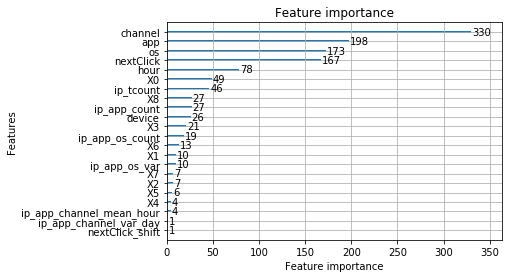

In [4]:
if WHERE!='gcloud':
    print('Plot feature importances...')
    ax = lgb.plot_importance(bst, max_num_features=100)
    plt.show()

Values less than 10:
X7, X2, X5, X4, ipp_app_channel_mean_hour, ip_app_channel_var_day, nextClick_shift

# Experiment 3 

In [5]:
"""
A non-blending lightGBM model that incorporates portions and ideas from various public kernels.
"""
DEBUG = False
WHERE = 'kaggle'
FILENO = 4
NCHUNK = 32000000
OFFSET = 75000000
VAL_RUN = False

MISSING32 = 999999999
MISSING8 = 255
PUBLIC_CUTOFF = 4032690

if WHERE=='kaggle':
	inpath = '../../../data/adfraud/'
	pickle_path ='../../../data/adfraud/'
	suffix = ''
	outpath = ''
	savepath = ''
	oofpath = ''
	cores = 4
elif WHERE=='gcloud':
	inpath = '../.kaggle/competitions/talkingdata-adtracking-fraud-detection/'
	pickle_path = '../data/'
	suffix = '.zip'
	outpath = '../sub/'
	oofpath = '../oof/'
	savepath = '../data/'
	cores = 7

import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt
import os

def do_count( df, group_cols, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Aggregating by ", group_cols , '...' )
    gp = df[group_cols][group_cols].groupby(group_cols).size().rename(agg_name).to_frame().reset_index()
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_countuniq( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Counting unqiue ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )
    
def do_cumcount( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Cumulative count by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].cumcount()
    df[agg_name]=gp.values
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_mean( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Calculating mean of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].mean().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_var( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Calculating variance of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].var().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

debug = DEBUG
if debug:
    print('*** debug parameter set: this is a test run for debugging purposes ***')

    
if VAL_RUN:
    nrows=122071522
    outpath = oofpath
else:
    nrows=184903890
nchunk=NCHUNK
val_size=2500000
frm=nrows-OFFSET
if debug:
    frm=0
    nchunk=100000
    val_size=10000
to=frm+nchunk
fileno = FILENO

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32',
        }

if VAL_RUN:
    print('loading train data...',frm,to)
    train_df = pd.read_pickle( pickle_path+"training.pkl.gz" )[frm:to]
    train_df['click_time'] = pd.to_datetime( train_df.click_time )
    print('loading test data...')
    if debug:
        public_cutoff = 10000
        test_df = pd.read_pickle( pickle_path+"validation.pkl.gz" )[:30000]
        test_df['click_time'] = pd.to_datetime( test_df.click_time )
        y_test = test_df['is_attributed'].values
        test_df.drop(['is_attributed'],axis=1,inplace=True)
    else:
        public_cutoff = PUBLIC_CUTOFF
        test_df = pd.read_pickle( pickle_path+"validation.pkl.gz" )
        test_df['click_time'] = pd.to_datetime( test_df.click_time )
        y_test = test_df['is_attributed'].values
        test_df.drop(['is_attributed'],axis=1,inplace=True)
else:
    print('loading train data...',frm,to)
    train_df = pd.read_csv(inpath+"train.csv", parse_dates=['click_time'], skiprows=range(1,frm), nrows=to-frm, dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])
    print('loading test data...')
    if debug:
        test_df = pd.read_csv(inpath+"test.csv", nrows=100000, parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
    else:
        test_df = pd.read_csv(inpath+"test.csv", parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
    train_df['click_id'] = MISSING32
    train_df['click_id'] = train_df.click_id.astype('uint32')


len_train = len(train_df)
test_df['is_attributed'] = MISSING8
test_df['is_attributed'] = test_df.is_attributed.astype('uint8')
train_df=train_df.append(test_df)

del test_df
gc.collect()

print('Extracting new features...')
train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('uint8')
train_df['day'] = pd.to_datetime(train_df.click_time).dt.day.astype('uint8')

print('Extracting aggregation features...')

train_df = do_cumcount( train_df, ['ip', 'device', 'os'], 'app', 'X1', show_max=True ); gc.collect()
#train_df = do_cumcount( train_df, ['ip'], 'os', 'X7', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip'], 'channel', 'X0', 'uint8', show_max=True ); gc.collect()
#train_df = do_countuniq( train_df, ['ip', 'day'], 'hour', 'X2', 'uint8', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip'], 'app', 'X3', 'uint8', show_max=True ); gc.collect()
#train_df = do_countuniq( train_df, ['ip', 'app'], 'os', 'X4', 'uint8', show_max=True ); gc.collect()
#train_df = do_countuniq( train_df, ['ip'], 'device', 'X5', 'uint16', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['app'], 'channel', 'X6', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip', 'device', 'os'], 'app', 'X8', show_max=True ); gc.collect()
train_df = do_count( train_df, ['ip', 'day', 'hour'], 'ip_tcount', show_max=True ); gc.collect()
train_df = do_count( train_df, ['ip', 'app'], 'ip_app_count', show_max=True ); gc.collect()
train_df = do_count( train_df, ['ip', 'app', 'os'], 'ip_app_os_count', 'uint16', show_max=True ); gc.collect()
train_df = do_var( train_df, ['ip', 'day', 'channel'], 'hour', 'ip_tchan_count', show_max=True ); gc.collect()
train_df = do_var( train_df, ['ip', 'app', 'os'], 'hour', 'ip_app_os_var', show_max=True ); gc.collect()
#train_df = do_var( train_df, ['ip', 'app', 'channel'], 'day', 'ip_app_channel_var_day', show_max=True ); gc.collect()
#train_df = do_mean( train_df, ['ip', 'app', 'channel'], 'hour', 'ip_app_channel_mean_hour', show_max=True ); gc.collect()

print('Doing nextClick...')
predictors=[]
new_feature = 'nextClick'
D=2**26
train_df['category'] = (train_df['ip'].astype(str) + "_" + train_df['app'].astype(str) + "_" + train_df['device'].astype(str) \
        + "_" + train_df['os'].astype(str)).apply(hash) % D
click_buffer= np.full(D, 3000000000, dtype=np.uint32)
train_df['epochtime']= train_df['click_time'].astype(np.int64) // 10 ** 9
next_clicks= []
for category, t in zip(reversed(train_df['category'].values), reversed(train_df['epochtime'].values)):
    next_clicks.append(click_buffer[category]-t)
    click_buffer[category]= t
del(click_buffer)
QQ= list(reversed(next_clicks))
train_df.drop(['epochtime','category','click_time'], axis=1, inplace=True)
train_df[new_feature] = pd.Series(QQ).astype('float32')
predictors.append(new_feature)


loading train data... 109903890 141903890
loading test data...
Extracting new features...
Extracting aggregation features...
Cumulative count by  ['ip', 'device', 'os'] ...
X1 max value =  74868
Counting unqiue  channel  by  ['ip'] ...
X0 max value =  130
Counting unqiue  app  by  ['ip'] ...
X3 max value =  202
Counting unqiue  channel  by  ['app'] ...
X6 max value =  43
Counting unqiue  app  by  ['ip', 'device', 'os'] ...
X8 max value =  78
Aggregating by  ['ip', 'day', 'hour'] ...
ip_tcount max value =  40231
Aggregating by  ['ip', 'app'] ...
ip_app_count max value =  61543
Aggregating by  ['ip', 'app', 'os'] ...
ip_app_os_count max value =  15946
Calculating variance of  hour  by  ['ip', 'day', 'channel'] ...
ip_tchan_count max value =  60.5
Calculating variance of  hour  by  ['ip', 'app', 'os'] ...
ip_app_os_var max value =  264.5
Doing nextClick...


In [6]:
# train_df[new_feature+'_shift'] = train_df[new_feature].shift(+1).values
# predictors.append(new_feature+'_shift')
del QQ, next_clicks
gc.collect()

print("vars and data type: ")
train_df.info()
train_df['ip_tcount'] = train_df['ip_tcount'].astype('uint16')
train_df['ip_app_count'] = train_df['ip_app_count'].astype('uint16')
train_df['ip_app_os_count'] = train_df['ip_app_os_count'].astype('uint16')

target = 'is_attributed'
predictors.extend(['app','device','os', 'channel', 'hour', 'day',
              'ip_tcount', 'ip_tchan_count', 'ip_app_count',
              'ip_app_os_count', 'ip_app_os_var',
              #'ip_app_channel_var_day','ip_app_channel_mean_hour',
              'X0', 'X1', #'X2', 
                   'X3', #'X4', 'X5', 
                   'X6', #'X7', 
                   'X8'])
categorical = ['app', 'device', 'os', 'channel', 'hour', 'day']
print('predictors',predictors)

test_df = train_df[len_train:]
val_df = train_df[(len_train-val_size):len_train]
train_df = train_df[:(len_train-val_size)]

print("train size: ", len(train_df))
print("valid size: ", len(val_df))
print("test size : ", len(test_df))

test_df.to_pickle('test.pkl.gz')
del test_df
gc.collect()

print("Training...")
start_time = time.time()

objective='binary' 
metrics='auc'
early_stopping_rounds=30 
verbose_eval=True 
num_boost_round=1000
categorical_features=categorical
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': objective,
    'metric':metrics,
    'learning_rate': 0.10,
    #'is_unbalance': 'true', # replaced with scale_pos_weight argument
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':200, # because training data is extremely unbalanced 
    'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 0,  # L2 regularization term on weights
    'nthread': cores,
    'verbose': 0,
    'metric':metrics
}

print("preparing validation datasets")
xgtrain = lgb.Dataset(train_df[predictors].values, label=train_df[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
                      
print( train_df[predictors].head() )
print( train_df[target].head() )
print( val_df[predictors].head() )
print( val_df[target].head() )

del train_df
if WHERE != 'kaggle':
    xgtrain.save_binary('xgtrain.bin')
    del xgtrain
xgvalid = lgb.Dataset(val_df[predictors].values, label=val_df[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
del val_df
gc.collect()

evals_results = {}

if WHERE != 'kaggle':
    xgtrain = lgb.Dataset('xgtrain.bin',
                          feature_name=predictors,
                          categorical_feature=categorical
                          )
                      
print( lgb_params )
bst = lgb.train(lgb_params, 
                 xgtrain, 
                 valid_sets=[xgvalid], 
                 valid_names=['valid'], 
                 evals_result=evals_results, 
                 num_boost_round=num_boost_round,
                 early_stopping_rounds=early_stopping_rounds,
                 verbose_eval=10, 
                 feval=None)

print("\nModel Report")
print("bst.best_iteration: ", bst.best_iteration)
print(metrics+":", evals_results['valid'][metrics][bst.best_iteration-1])


print('[{}]: model training time'.format(time.time() - start_time))

vars and data type: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50790469 entries, 0 to 50790468
Data columns (total 20 columns):
app                uint16
channel            uint16
click_id           uint32
device             uint16
ip                 uint32
is_attributed      uint8
os                 uint16
hour               uint8
day                uint8
X1                 uint32
X0                 uint8
X3                 uint8
X6                 uint32
X8                 uint32
ip_tcount          uint32
ip_app_count       uint32
ip_app_os_count    uint16
ip_tchan_count     float32
ip_app_os_var      float32
nextClick          float32
dtypes: float32(3), uint16(5), uint32(7), uint8(5)
memory usage: 3.0 GB
predictors ['nextClick', 'app', 'device', 'os', 'channel', 'hour', 'day', 'ip_tcount', 'ip_tchan_count', 'ip_app_count', 'ip_app_os_count', 'ip_app_os_var', 'X0', 'X1', 'X2', 'X3', 'X6', 'X8']
train size:  29500000
valid size:  2500000
test size :  18790469
Training...
prep

KeyError: "['X2'] not in index"

In [8]:
predictors.remove('X2')
print(predictors)

['nextClick', 'app', 'device', 'os', 'channel', 'hour', 'day', 'ip_tcount', 'ip_tchan_count', 'ip_app_count', 'ip_app_os_count', 'ip_app_os_var', 'X0', 'X1', 'X3', 'X6', 'X8']


In [9]:
print("preparing validation datasets")
xgtrain = lgb.Dataset(train_df[predictors].values, label=train_df[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
                      
print( train_df[predictors].head() )
print( train_df[target].head() )
print( val_df[predictors].head() )
print( val_df[target].head() )

del train_df
if WHERE != 'kaggle':
    xgtrain.save_binary('xgtrain.bin')
    del xgtrain
xgvalid = lgb.Dataset(val_df[predictors].values, label=val_df[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
del val_df
gc.collect()

evals_results = {}

if WHERE != 'kaggle':
    xgtrain = lgb.Dataset('xgtrain.bin',
                          feature_name=predictors,
                          categorical_feature=categorical
                          )
                      
print( lgb_params )
bst = lgb.train(lgb_params, 
                 xgtrain, 
                 valid_sets=[xgvalid], 
                 valid_names=['valid'], 
                 evals_result=evals_results, 
                 num_boost_round=num_boost_round,
                 early_stopping_rounds=early_stopping_rounds,
                 verbose_eval=10, 
                 feval=None)

print("\nModel Report")
print("bst.best_iteration: ", bst.best_iteration)
print(metrics+":", evals_results['valid'][metrics][bst.best_iteration-1])


print('[{}]: model training time'.format(time.time() - start_time))

preparing validation datasets
      nextClick  app  device  os  channel  hour  day  ip_tcount  \
0  1.489856e+09   23       1  16      153    12    8          9   
1  8.400000e+01    3       1  19      280    12    8         43   
2  3.400000e+01   12       1  17      178    12    8         18   
3  4.400000e+01    3       1  42      280    12    8         42   
4  4.100000e+01    3       1  19      130    12    8         19   

   ip_tchan_count  ip_app_count  ip_app_os_count  ip_app_os_var  X0  X1  X3  \
0             NaN            13                1            NaN  66   0  23   
1        7.364437           192               41      34.559757  77   0  28   
2             NaN            28                2       0.000000  25   0  16   
3        7.923695           304                3       0.000000  87   0  38   
4       22.700001           185               82      57.324451  80   0  29   

   X6  X8  
0   7   9  
1  43  16  
2  31   2  
3  43   2  
4  43  23  
0    0
1    0
2    0

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	valid's auc: 0.965782
[20]	valid's auc: 0.972304
[30]	valid's auc: 0.975117
[40]	valid's auc: 0.97641
[50]	valid's auc: 0.97729
[60]	valid's auc: 0.977874
[70]	valid's auc: 0.978238
[80]	valid's auc: 0.978567
[90]	valid's auc: 0.978769
[100]	valid's auc: 0.978939
[110]	valid's auc: 0.979066
[120]	valid's auc: 0.979181
[130]	valid's auc: 0.979263
[140]	valid's auc: 0.979362
[150]	valid's auc: 0.979438
[160]	valid's auc: 0.979514
[170]	valid's auc: 0.979548
[180]	valid's auc: 0.979578
[190]	valid's auc: 0.979564
[200]	valid's auc: 0.979623
[210]	valid's auc: 0.979529
[220]	valid's auc: 0.979524
Early stopping, best iteration is:
[198]	valid's auc: 0.97963

Model Report
bst.best_iteration:  198
auc: 0.979629893905
[707.5820024013519]: model training time


Plot feature importances...


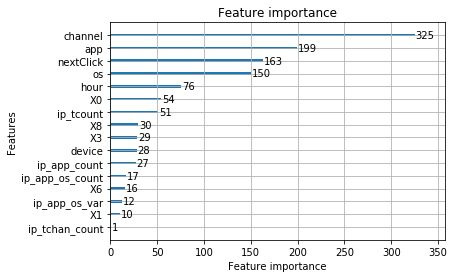

In [10]:
if WHERE!='gcloud':
    print('Plot feature importances...')
    ax = lgb.plot_importance(bst, max_num_features=100)
    plt.show()

# Experiment 4

In [5]:
"""
A non-blending lightGBM model that incorporates portions and ideas from various public kernels.
"""
DEBUG = False
WHERE = 'kaggle'
FILENO = 4
NCHUNK = 32000000
OFFSET = 75000000
VAL_RUN = False

MISSING32 = 999999999
MISSING8 = 255
PUBLIC_CUTOFF = 4032690

if WHERE=='kaggle':
	inpath = 'data/fraud-detection/'#'../../../data/adfraud/'
	pickle_path ='data/fraud-detection/'#'../../../data/adfraud/'
	suffix = ''
	outpath = ''
	savepath = ''
	oofpath = ''
	cores = 4
elif WHERE=='gcloud':
	inpath = '../.kaggle/competitions/talkingdata-adtracking-fraud-detection/'
	pickle_path = '../data/'
	suffix = '.zip'
	outpath = '../sub/'
	oofpath = '../oof/'
	savepath = '../data/'
	cores = 7

import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt
import os

def do_rollingstd(df, group_cols, agg_name, agg_type='float32', window_size=5, show_max=False, show_agg=True):
    # suggest trying 'app', 'channel', 'hour'] to start
    if show_agg:
        print( "Doing rolling std dev of ", group_cols , '...')
    c_gp = df[group_cols].groupby(group_cols).size().rename('gp_count').to_frame().reset_index()
    df = df.merge(c_gp, on=group_cols, how='left')
    del c_gp
    gc.collect()
    df2 = df[group_cols+['gp_count']].drop_duplicates()
    df2['ma']=df2.groupby('channel')['gp_count'].rolling(2).mean().reset_index(0,drop=True)
    df2['res'] = df2['gp_count'] - df2['ma']
    df2.drop(['gp_count', 'res'], axis=1, inplace=True)
    df2[agg_name]=df2.groupby('channel')['ma'].rolling(2).std().reset_index(0,drop=True)
    df2.drop('ma', axis=1, inplace=True)
    df = df.merge(df2, on=group_cols, how='left')
    del df2
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    gc.collect()
    #print(df[agg_name].count())
    #print(df[[agg_name]+['channel', 'hour']][df['channel']==379])#.iloc[60000:60010])
    df[agg_name].fillna(-999, inplace=True)
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return(df)
    
def do_count( df, group_cols, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Aggregating by ", group_cols , '...' )
    gp = df[group_cols].groupby(group_cols).size().rename(agg_name).to_frame().reset_index()
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_countuniq( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Counting unqiue ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )
    
def do_cumcount( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Cumulative count by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].cumcount()
    df[agg_name]=gp.values
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_mean( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Calculating mean of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].mean().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_var( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Calculating variance of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].var().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

debug = DEBUG
if debug:
    print('*** debug parameter set: this is a test run for debugging purposes ***')

    
if VAL_RUN:
    nrows=122071522
    outpath = oofpath
else:
    nrows=184903890
nchunk=NCHUNK
val_size=2500000
frm=nrows-OFFSET
if debug:
    frm=0
    nchunk=100000
    val_size=10000
to=frm+nchunk
fileno = FILENO

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32',
        }

if VAL_RUN:
    print('loading train data...',frm,to)
    train_df = pd.read_pickle( pickle_path+"training.pkl.gz" )[frm:to]
    train_df['click_time'] = pd.to_datetime( train_df.click_time )
    print('loading test data...')
    if debug:
        public_cutoff = 10000
        test_df = pd.read_pickle( pickle_path+"validation.pkl.gz" )[:30000]
        test_df['click_time'] = pd.to_datetime( test_df.click_time )
        y_test = test_df['is_attributed'].values
        test_df.drop(['is_attributed'],axis=1,inplace=True)
    else:
        public_cutoff = PUBLIC_CUTOFF
        test_df = pd.read_pickle( pickle_path+"validation.pkl.gz" )
        test_df['click_time'] = pd.to_datetime( test_df.click_time )
        y_test = test_df['is_attributed'].values
        test_df.drop(['is_attributed'],axis=1,inplace=True)
else:
    print('loading train data...',frm,to)
    train_df = pd.read_csv(inpath+"train.csv", parse_dates=['click_time'], skiprows=range(1,frm), nrows=to-frm, dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])
    print('loading test data...')
    if debug:
        test_df = pd.read_csv(inpath+"test.csv", nrows=100000, parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
    else:
        test_df = pd.read_csv(inpath+"test.csv", parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
    train_df['click_id'] = MISSING32
    train_df['click_id'] = train_df.click_id.astype('uint32')


len_train = len(train_df)
test_df['is_attributed'] = MISSING8
test_df['is_attributed'] = test_df.is_attributed.astype('uint8')
train_df=train_df.append(test_df)

del test_df
gc.collect()

print('Extracting new features...')
train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('uint8')
train_df['day'] = pd.to_datetime(train_df.click_time).dt.day.astype('uint8')

print('Extracting aggregation features...')

train_df = do_rollingstd(train_df, ['channel', 'hour'], 'rolling', window_size=3, show_max=True, show_agg=True); gc.collect()
train_df = do_cumcount( train_df, ['ip', 'device', 'os'], 'app', 'X1', show_max=True ); gc.collect()
#train_df = do_cumcount( train_df, ['ip'], 'os', 'X7', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip'], 'channel', 'X0', 'uint8', show_max=True ); gc.collect()
#train_df = do_countuniq( train_df, ['ip', 'day'], 'hour', 'X2', 'uint8', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip'], 'app', 'X3', 'uint8', show_max=True ); gc.collect()
#train_df = do_countuniq( train_df, ['ip', 'app'], 'os', 'X4', 'uint8', show_max=True ); gc.collect()
#train_df = do_countuniq( train_df, ['ip'], 'device', 'X5', 'uint16', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['app'], 'channel', 'X6', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip', 'device', 'os'], 'app', 'X8', show_max=True ); gc.collect()
train_df = do_count( train_df, ['ip', 'day', 'hour'], 'ip_tcount', show_max=True ); gc.collect()
train_df = do_count( train_df, ['ip', 'app'], 'ip_app_count', show_max=True ); gc.collect()
train_df = do_count( train_df, ['ip', 'app', 'os'], 'ip_app_os_count', 'uint16', show_max=True ); gc.collect()
#train_df = do_var( train_df, ['ip', 'day', 'channel'], 'hour', 'ip_tchan_count', show_max=True ); gc.collect()
train_df = do_var( train_df, ['ip', 'app', 'os'], 'hour', 'ip_app_os_var', show_max=True ); gc.collect()
#train_df = do_var( train_df, ['ip', 'app', 'channel'], 'day', 'ip_app_channel_var_day', show_max=True ); gc.collect()
#train_df = do_mean( train_df, ['ip', 'app', 'channel'], 'hour', 'ip_app_channel_mean_hour', show_max=True ); gc.collect()

print('Doing nextClick...')
predictors=[]
new_feature = 'nextClick'
D=2**26
train_df['category'] = (train_df['ip'].astype(str) + "_" + train_df['app'].astype(str) + "_" + train_df['device'].astype(str) \
        + "_" + train_df['os'].astype(str)).apply(hash) % D
click_buffer= np.full(D, 3000000000, dtype=np.uint32)
train_df['epochtime']= train_df['click_time'].astype(np.int64) // 10 ** 9
next_clicks= []
for category, t in zip(reversed(train_df['category'].values), reversed(train_df['epochtime'].values)):
    next_clicks.append(click_buffer[category]-t)
    click_buffer[category]= t
del(click_buffer)
QQ= list(reversed(next_clicks))
train_df.drop(['epochtime','category','click_time'], axis=1, inplace=True)
train_df[new_feature] = pd.Series(QQ).astype('float32')
predictors.append(new_feature)


loading train data... 109903890 141903890
loading test data...
Extracting new features...
Extracting aggregation features...
Doing rolling std dev of  ['channel', 'hour'] ...
rolling max value =  173818.51407754296
Cumulative count by  ['ip', 'device', 'os'] ...
X1 max value =  74868
Counting unqiue  channel  by  ['ip'] ...
X0 max value =  130
Counting unqiue  app  by  ['ip'] ...
X3 max value =  202
Counting unqiue  channel  by  ['app'] ...
X6 max value =  43
Counting unqiue  app  by  ['ip', 'device', 'os'] ...
X8 max value =  78
Aggregating by  ['ip', 'day', 'hour'] ...
ip_tcount max value =  40231
Aggregating by  ['ip', 'app'] ...
ip_app_count max value =  61543
Aggregating by  ['ip', 'app', 'os'] ...
ip_app_os_count max value =  15946
Calculating variance of  hour  by  ['ip', 'app', 'os'] ...
ip_app_os_var max value =  264.5
Doing nextClick...


In [6]:
del QQ, next_clicks
gc.collect()

print("vars and data type: ")
train_df.info()
train_df['ip_tcount'] = train_df['ip_tcount'].astype('uint16')
train_df['ip_app_count'] = train_df['ip_app_count'].astype('uint16')
train_df['ip_app_os_count'] = train_df['ip_app_os_count'].astype('uint16')

target = 'is_attributed'
predictors.extend(['app','device','os', 'channel', 'hour', 'day',
              'ip_tcount', #'ip_tchan_count', 
              'ip_app_count',
              'ip_app_os_count', 'ip_app_os_var',
              #'ip_app_channel_var_day','ip_app_channel_mean_hour',
              'X0', 'X1', #'X2', 
                   'X3', #'X4', 'X5', 
                   'X6', #'X7', 
                   'X8', 'rolling'])
categorical = ['app', 'device', 'os', 'channel', 'hour', 'day']
print('predictors',predictors)

test_df = train_df[len_train:]
val_df = train_df[(len_train-val_size):len_train]
train_df = train_df[:(len_train-val_size)]

print("train size: ", len(train_df))
print("valid size: ", len(val_df))
print("test size : ", len(test_df))

test_df.to_pickle('test.pkl.gz')
del test_df
gc.collect()

print("Training...")
start_time = time.time()

objective='binary' 
metrics='auc'
early_stopping_rounds=30 
verbose_eval=True 
num_boost_round=1000
categorical_features=categorical
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': objective,
    'metric':metrics,
    'learning_rate': 0.10,
    #'is_unbalance': 'true', # replaced with scale_pos_weight argument
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':200, # because training data is extremely unbalanced 
    'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 0,  # L2 regularization term on weights
    'nthread': cores,
    'verbose': 0,
    'metric':metrics
}

print("preparing validation datasets")
xgtrain = lgb.Dataset(train_df[predictors].values, label=train_df[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
                      
print( train_df[predictors].head() )
print( train_df[target].head() )
print( val_df[predictors].head() )
print( val_df[target].head() )

del train_df
if WHERE != 'kaggle':
    xgtrain.save_binary('xgtrain.bin')
    del xgtrain
xgvalid = lgb.Dataset(val_df[predictors].values, label=val_df[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
del val_df
gc.collect()

evals_results = {}

if WHERE != 'kaggle':
    xgtrain = lgb.Dataset('xgtrain.bin',
                          feature_name=predictors,
                          categorical_feature=categorical
                          )
                      
print( lgb_params )
bst = lgb.train(lgb_params, 
                 xgtrain, 
                 valid_sets=[xgvalid], 
                 valid_names=['valid'], 
                 evals_result=evals_results, 
                 num_boost_round=num_boost_round,
                 early_stopping_rounds=early_stopping_rounds,
                 verbose_eval=10, 
                 feval=None)

print("\nModel Report")
print("bst.best_iteration: ", bst.best_iteration)
print(metrics+":", evals_results['valid'][metrics][bst.best_iteration-1])


print('[{}]: model training time'.format(time.time() - start_time))

vars and data type: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50790469 entries, 0 to 50790468
Data columns (total 21 columns):
app                uint16
channel            uint16
click_id           uint32
device             uint16
ip                 uint32
is_attributed      uint8
os                 uint16
hour               uint8
day                uint8
gp_count           int64
rolling            float32
X1                 uint32
X0                 uint8
X3                 uint8
X6                 uint32
X8                 uint32
ip_tcount          uint32
ip_app_count       uint32
ip_app_os_count    uint16
ip_app_os_var      float32
nextClick          float32
dtypes: float32(3), int64(1), uint16(5), uint32(7), uint8(5)
memory usage: 3.4 GB
predictors ['nextClick', 'app', 'device', 'os', 'channel', 'hour', 'day', 'ip_tcount', 'ip_app_count', 'ip_app_os_count', 'ip_app_os_var', 'X0', 'X1', 'X3', 'X6', 'X8', 'rolling']
train size:  29500000
valid size:  2500000
test size :  187

/home/zlandes/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/zlandes/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	valid's auc: 0.965888
[20]	valid's auc: 0.972633
[30]	valid's auc: 0.975098
[40]	valid's auc: 0.976509
[50]	valid's auc: 0.97741
[60]	valid's auc: 0.977916
[70]	valid's auc: 0.978501
[80]	valid's auc: 0.978759
[90]	valid's auc: 0.97896
[100]	valid's auc: 0.979111
[110]	valid's auc: 0.979187
[120]	valid's auc: 0.979287
[130]	valid's auc: 0.97938
[140]	valid's auc: 0.979517
[150]	valid's auc: 0.979554
[160]	valid's auc: 0.979631
[170]	valid's auc: 0.979667
[180]	valid's auc: 0.979745
[190]	valid's auc: 0.979721
[200]	valid's auc: 0.9797
[210]	valid's auc: 0.979685
[220]	valid's auc: 0.979686
Early stopping, best iteration is:
[196]	valid's auc: 0.979761

Model Report
bst.best_iteration:  196
auc: 0.979760514197434
[210.3561511039734]: model training time


Plot feature importances...


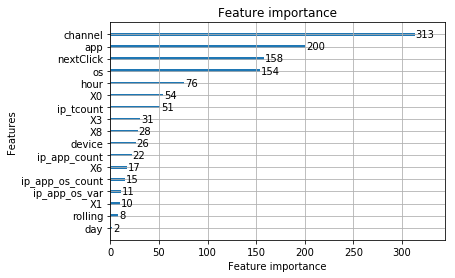

In [7]:
if WHERE!='gcloud':
    print('Plot feature importances...')
    ax = lgb.plot_importance(bst, max_num_features=100)
    plt.show()

# Experiment 5

In [11]:
"""
A non-blending lightGBM model that incorporates portions and ideas from various public kernels.
"""
DEBUG = False
WHERE = 'kaggle'
FILENO = 4
NCHUNK = 32000000
OFFSET = 75000000
VAL_RUN = False

MISSING32 = 999999999
MISSING8 = 255
PUBLIC_CUTOFF = 4032690

if WHERE=='kaggle':
	inpath = '../../../data/adfraud/' #'data/fraud-detection/'
	pickle_path ='../../../data/adfraud/' #'data/fraud-detection/'
	suffix = ''
	outpath = ''
	savepath = ''
	oofpath = ''
	cores = 4
elif WHERE=='gcloud':
	inpath = '../.kaggle/competitions/talkingdata-adtracking-fraud-detection/'
	pickle_path = '../data/'
	suffix = '.zip'
	outpath = '../sub/'
	oofpath = '../oof/'
	savepath = '../data/'
	cores = 7

import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt
import os

def do_skew( df, group_cols, counted, agg_name, agg_type='float16', show_max=False, show_agg=True ):
    if show_agg:
        print( "Calculating skew of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].skew().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_rollingstd(df, group_cols, agg_name, agg_type='float32', window_size=5, show_max=False, show_agg=True):
    # suggest trying 'app', 'channel', 'hour'] to start
    if show_agg:
        print( "Doing rolling std dev of ", group_cols , '...')
    c_gp = df[group_cols].groupby(group_cols).size().rename('gp_count').to_frame().reset_index()
    df = df.merge(c_gp, on=group_cols, how='left')
    del c_gp
    gc.collect()
    df2 = df[group_cols+['gp_count']].drop_duplicates()
    df2['ma']=df2.groupby('channel')['gp_count'].rolling(2).mean().reset_index(0,drop=True)
    df2['res'] = df2['gp_count'] - df2['ma']
    df2.drop(['gp_count', 'res'], axis=1, inplace=True)
    df2[agg_name]=df2.groupby('channel')['ma'].rolling(2).std().reset_index(0,drop=True)
    df2.drop('ma', axis=1, inplace=True)
    df = df.merge(df2, on=group_cols, how='left')
    del df2
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    gc.collect()
    #print(df[agg_name].count())
    #print(df[[agg_name]+['channel', 'hour']][df['channel']==379])#.iloc[60000:60010])
    df[agg_name].fillna(-999, inplace=True)
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return(df)
    
def do_count( df, group_cols, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Aggregating by ", group_cols , '...' )
    gp = df[group_cols].groupby(group_cols).size().rename(agg_name).to_frame().reset_index()
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_countuniq( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Counting unqiue ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )
    
def do_cumcount( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Cumulative count by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].cumcount()
    df[agg_name]=gp.values
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_mean( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Calculating mean of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].mean().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_var( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Calculating variance of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].var().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

debug = DEBUG
if debug:
    print('*** debug parameter set: this is a test run for debugging purposes ***')

    
if VAL_RUN:
    nrows=122071522
    outpath = oofpath
else:
    nrows=184903890
nchunk=NCHUNK
val_size=2500000
frm=nrows-OFFSET
if debug:
    frm=0
    nchunk=100000
    val_size=10000
to=frm+nchunk
fileno = FILENO

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32',
        }

if VAL_RUN:
    print('loading train data...',frm,to)
    train_df = pd.read_pickle( pickle_path+"training.pkl.gz" )[frm:to]
    train_df['click_time'] = pd.to_datetime( train_df.click_time )
    print('loading test data...')
    if debug:
        public_cutoff = 10000
        test_df = pd.read_pickle( pickle_path+"validation.pkl.gz" )[:30000]
        test_df['click_time'] = pd.to_datetime( test_df.click_time )
        y_test = test_df['is_attributed'].values
        test_df.drop(['is_attributed'],axis=1,inplace=True)
    else:
        public_cutoff = PUBLIC_CUTOFF
        test_df = pd.read_pickle( pickle_path+"validation.pkl.gz" )
        test_df['click_time'] = pd.to_datetime( test_df.click_time )
        y_test = test_df['is_attributed'].values
        test_df.drop(['is_attributed'],axis=1,inplace=True)
else:
    print('loading train data...',frm,to)
    train_df = pd.read_csv(inpath+"train.csv", parse_dates=['click_time'], skiprows=range(1,frm), nrows=to-frm, dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])
    print('loading test data...')
    if debug:
        test_df = pd.read_csv(inpath+"test.csv", nrows=100000, parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
    else:
        test_df = pd.read_csv(inpath+"test.csv", parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
    train_df['click_id'] = MISSING32
    train_df['click_id'] = train_df.click_id.astype('uint32')


len_train = len(train_df)
test_df['is_attributed'] = MISSING8
test_df['is_attributed'] = test_df.is_attributed.astype('uint8')
train_df=train_df.append(test_df)

del test_df
gc.collect()

print('Extracting new features...')
train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('uint8')
train_df['day'] = pd.to_datetime(train_df.click_time).dt.day.astype('uint8')
ns5min=5*60*1000000000
train_df['fives'] = pd.to_datetime(((train_df.click_time.astype(np.int64) // ns5min + 1 ) * ns5min)).dt.minute.astype('uint8')
ns3hr=3*60*60*1000000000
# train_df['3_hours'] = pd.to_datetime(((train_df.click_time.astype(np.int64) // ns3hr + 1 ) * ns3hr)).dt.minute.astype('uint8')
# ns3hr=6*60*60*1000000000
# train_df['6_hours'] = pd.to_datetime(((train_df.click_time.astype(np.int64) // ns3hr + 1 ) * ns3hr)).dt.minute.astype('uint8')

print('Extracting aggregation features...')

train_df = do_rollingstd(train_df, ['channel', 'hour'], 'rolling', window_size=3, show_max=True, show_agg=True); gc.collect()
#train_df = do_rollingstd(train_df, ['ip', 'channel', 'hour'], 'ip_rolling', window_size=3, show_max=True, show_agg=True); gc.collect()
train_df = do_cumcount( train_df, ['ip', 'device', 'os'], 'app', 'X1', show_max=True ); gc.collect()
#train_df = do_cumcount( train_df, ['ip'], 'os', 'X7', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip'], 'channel', 'X0', 'uint8', show_max=True ); gc.collect()
#train_df = do_countuniq( train_df, ['ip', 'day'], 'hour', 'X2', 'uint8', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip'], 'app', 'X3', 'uint8', show_max=True ); gc.collect()
#train_df = do_countuniq( train_df, ['ip', 'app'], 'os', 'X4', 'uint8', show_max=True ); gc.collect()
#train_df = do_countuniq( train_df, ['ip'], 'device', 'X5', 'uint16', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['app'], 'channel', 'X6', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip', 'device', 'os'], 'app', 'X8', show_max=True ); gc.collect()
train_df = do_count( train_df, ['ip', 'day', 'hour'], 'ip_tcount', show_max=True ); gc.collect()
train_df = do_count( train_df, ['ip', 'app'], 'ip_app_count', show_max=True ); gc.collect()
train_df = do_count( train_df, ['ip', 'app', 'os'], 'ip_app_os_count', 'uint16', show_max=True ); gc.collect()
#train_df = do_var( train_df, ['ip', 'day', 'channel'], 'hour', 'ip_tchan_count', show_max=True ); gc.collect()
train_df = do_var( train_df, ['ip', 'app', 'os'], 'hour', 'ip_app_os_var', show_max=True ); gc.collect()
train_df = do_skew( train_df, ['ip', 'app', 'os'], 'hour', 'ip_app_os_skew', show_max=True ); gc.collect()
train_df = do_var( train_df, ['ip', 'app', 'os', 'hour'], 'fives', 'ip_app_os_h_5_var', show_max=True ); gc.collect()
train_df = do_skew( train_df, ['ip', 'app', 'os', 'hour'], 'fives', 'ip_app_os_h_5_skew', show_max=True ); gc.collect()
train_df = do_var( train_df, ['ip', 'app', 'os'], 'fives', 'ip_app_os_5_var', show_max=True ); gc.collect()
train_df = do_skew( train_df, ['ip', 'app', 'os'], 'fives', 'ip_app_os_5_skew', show_max=True ); gc.collect()
#train_df = do_var( train_df, ['ip', 'app', 'os'], '3_hours', 'ip_app_os_3_var', show_max=True ); gc.collect()
#train_df = do_skew( train_df, ['ip', 'app', 'os'], '3_hours', 'ip_app_os_3_skew', show_max=True ); gc.collect()
#train_df = do_var( train_df, ['ip', 'app', 'os'], '6_hours', 'ip_app_os_6_var', show_max=True ); gc.collect()
#train_df = do_skew( train_df, ['ip', 'app', 'os'], '6_hours', 'ip_app_os_6_skew', show_max=True ); gc.collect()
#train_df = do_var( train_df, ['ip', 'app', 'channel'], 'day', 'ip_app_channel_var_day', show_max=True ); gc.collect()
#train_df = do_mean( train_df, ['ip', 'app', 'channel'], 'hour', 'ip_app_channel_mean_hour', show_max=True ); gc.collect()

print('Doing nextClick...')
predictors=[]
new_feature = 'nextClick'
D=2**26
train_df['category'] = (train_df['ip'].astype(str) + "_" + train_df['app'].astype(str) + "_" + train_df['device'].astype(str) \
        + "_" + train_df['os'].astype(str)).apply(hash) % D
click_buffer= np.full(D, 3000000000, dtype=np.uint32)
train_df['epochtime']= train_df['click_time'].astype(np.int64) // 10 ** 9
next_clicks= []
for category, t in zip(reversed(train_df['category'].values), reversed(train_df['epochtime'].values)):
    next_clicks.append(click_buffer[category]-t)
    click_buffer[category]= t
del(click_buffer)
QQ= list(reversed(next_clicks))
train_df.drop(['epochtime','category','click_time', 'day'], axis=1, inplace=True)
train_df[new_feature] = pd.Series(QQ).astype('float32')
predictors.append(new_feature)


loading train data... 109903890 141903890
loading test data...
Extracting new features...
Extracting aggregation features...
Doing rolling std dev of  ['channel', 'hour'] ...
rolling max value =  173818.514078
Cumulative count by  ['ip', 'device', 'os'] ...
X1 max value =  74868
Counting unqiue  channel  by  ['ip'] ...
X0 max value =  130
Counting unqiue  app  by  ['ip'] ...
X3 max value =  202
Counting unqiue  channel  by  ['app'] ...
X6 max value =  43
Counting unqiue  app  by  ['ip', 'device', 'os'] ...
X8 max value =  78
Aggregating by  ['ip', 'day', 'hour'] ...
ip_tcount max value =  40231
Aggregating by  ['ip', 'app'] ...
ip_app_count max value =  61543
Aggregating by  ['ip', 'app', 'os'] ...
ip_app_os_count max value =  15946
Calculating variance of  hour  by  ['ip', 'app', 'os'] ...
ip_app_os_var max value =  264.5
Calculating skew of  hour  by  ['ip', 'app', 'os'] ...
ip_app_os_skew max value =  14.4222051019
Calculating variance of  fives  by  ['ip', 'app', 'os', 'hour'] ...


In [12]:
del QQ, next_clicks
gc.collect()

print("vars and data type: ")
train_df.info()
train_df['ip_tcount'] = train_df['ip_tcount'].astype('uint16')
train_df['ip_app_count'] = train_df['ip_app_count'].astype('uint16')
train_df['ip_app_os_count'] = train_df['ip_app_os_count'].astype('uint16')

target = 'is_attributed'
predictors.extend(['app','device','os', 'channel', 'hour',
              'ip_tcount', #'ip_tchan_count', 
              'ip_app_count',
              'ip_app_os_count', 'ip_app_os_var',
              #'ip_app_channel_var_day','ip_app_channel_mean_hour',
              'X0', 'X1', #'X2', 
                   'X3', #'X4', 'X5', 
                   'X6', #'X7', 
                   'X8', 'rolling',  'ip_app_os_h_5_var',
                  'ip_app_os_h_5_skew', 'ip_app_os_5_var', 'ip_app_os_5_skew',
                  'ip_app_os_skew'])
categorical = ['app', 'device', 'os', 'channel', 'hour']
print('predictors',predictors)

test_df = train_df[len_train:]
val_df = train_df[(len_train-val_size):len_train]
train_df = train_df[:(len_train-val_size)]

print("train size: ", len(train_df))
print("valid size: ", len(val_df))
print("test size : ", len(test_df))

test_df.to_pickle('test.pkl.gz')
del test_df
gc.collect()

print("Training...")
start_time = time.time()

objective='binary' 
metrics='auc'
early_stopping_rounds=30 
verbose_eval=True 
num_boost_round=1000
categorical_features=categorical
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': objective,
    'metric':metrics,
    'learning_rate': 0.10,
    #'is_unbalance': 'true', # replaced with scale_pos_weight argument
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':200, # because training data is extremely unbalanced 
    'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 0,  # L2 regularization term on weights
    'nthread': cores,
    'verbose': 0,
    'metric':metrics
}

print("preparing validation datasets")
xgtrain = lgb.Dataset(train_df[predictors].values, label=train_df[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
                      
print( train_df[predictors].head() )
print( train_df[target].head() )
print( val_df[predictors].head() )
print( val_df[target].head() )

del train_df
if WHERE != 'kaggle':
    xgtrain.save_binary('xgtrain.bin')
    del xgtrain
xgvalid = lgb.Dataset(val_df[predictors].values, label=val_df[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
del val_df
gc.collect()

evals_results = {}

if WHERE != 'kaggle':
    xgtrain = lgb.Dataset('xgtrain.bin',
                          feature_name=predictors,
                          categorical_feature=categorical
                          )
                      
print( lgb_params )
bst = lgb.train(lgb_params, 
                 xgtrain, 
                 valid_sets=[xgvalid], 
                 valid_names=['valid'], 
                 evals_result=evals_results, 
                 num_boost_round=num_boost_round,
                 early_stopping_rounds=early_stopping_rounds,
                 verbose_eval=10, 
                 feval=None)

print("\nModel Report")
print("bst.best_iteration: ", bst.best_iteration)
print(metrics+":", evals_results['valid'][metrics][bst.best_iteration-1])


print('[{}]: model training time'.format(time.time() - start_time))

vars and data type: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50790469 entries, 0 to 50790468
Data columns (total 26 columns):
app                   uint16
channel               uint16
click_id              uint32
device                uint16
ip                    uint32
is_attributed         uint8
os                    uint16
hour                  uint8
fives                 uint8
gp_count              int64
rolling               float32
X1                    uint32
X0                    uint8
X3                    uint8
X6                    uint32
X8                    uint32
ip_tcount             uint32
ip_app_count          uint32
ip_app_os_count       uint16
ip_app_os_var         float32
ip_app_os_skew        float16
ip_app_os_h_5_var     float32
ip_app_os_h_5_skew    float16
ip_app_os_5_var       float32
ip_app_os_5_skew      float16
nextClick             float32
dtypes: float16(3), float32(5), int64(1), uint16(5), uint32(7), uint8(5)
memory usage: 4.0 GB
predictors ['n

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	valid's auc: 0.967399
[20]	valid's auc: 0.973019
[30]	valid's auc: 0.975225
[40]	valid's auc: 0.97673
[50]	valid's auc: 0.977468
[60]	valid's auc: 0.978131
[70]	valid's auc: 0.978553
[80]	valid's auc: 0.978826
[90]	valid's auc: 0.979123
[100]	valid's auc: 0.979328
[110]	valid's auc: 0.97936
[120]	valid's auc: 0.979482
[130]	valid's auc: 0.979566
[140]	valid's auc: 0.97965
[150]	valid's auc: 0.97975
[160]	valid's auc: 0.979869
[170]	valid's auc: 0.979856
[180]	valid's auc: 0.979927
[190]	valid's auc: 0.979965
[200]	valid's auc: 0.979967
[210]	valid's auc: 0.979959
[220]	valid's auc: 0.979943
Early stopping, best iteration is:
[194]	valid's auc: 0.979986

Model Report
bst.best_iteration:  194
auc: 0.979986013532
[287.9658305644989]: model training time


Plot feature importances...


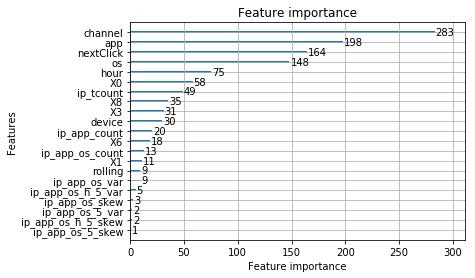

In [13]:
if WHERE!='gcloud':
    print('Plot feature importances...')
    ax = lgb.plot_importance(bst, max_num_features=100)
    plt.show()

Let's submit to check our validation:PL rank correlation

In [15]:
FILENO = 7
print("Re-reading test data...")
test_df = pd.read_pickle('test.pkl.gz')
sub = pd.DataFrame()

print("Predicting...")
y_pred = bst.predict(test_df[predictors],num_iteration=bst.best_iteration)
outsuf = ''
if VAL_RUN:
    print(  "\n\nFULL VALIDATION SCORE:    ", 
            roc_auc_score( y_test, y_pred )  )
    print(  "PUBLIC VALIDATION SCORE:  ", 
            roc_auc_score( y_test[:public_cutoff], y_pred[:public_cutoff] )  )
    print(  "PRIVATE VALIDATION SCORE: ",
            roc_auc_score( y_test[public_cutoff:], y_pred[public_cutoff:] )  )
    outsuf = '_val'
    sub['click_id'] = pd.Series(range(len(test_df))).astype('uint32').values
else:
    sub['click_id'] = test_df['click_id'].astype('uint32').values

if WHERE != 'kaggle':
    os.remove('xgtrain.bin')
os.remove('test.pkl.gz')
sub['is_attributed'] = y_pred
if not debug:
    print("\nwriting...")
#     if WHERE=='kaggle':
#         sub.to_csv('sub_it%d'%(fileno)+outsuf+'.csv', index=False, float_format='%.9f')
#     else:
    sub.to_csv('sub_it%d'%(fileno)+outsuf+'.csv.gz', index=False, float_format='%.9f', compression='gzip')
print("\ndone...")
print( sub.head(10) )

Re-reading test data...
Predicting...

writing...

done...
   click_id  is_attributed
0         0       0.152551
1         1       0.023258
2         2       0.001928
3         3       0.026008
4         4       0.010097
5         5       0.005236
6         6       0.024703
7         7       0.089449
8         9       0.135495
9         8       0.008930


# Experiment 6 